In [1]:
import os
import pandas as pd
import numpy as np
import xgboost
import shap
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score,classification_report,f1_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

In [2]:
test_files = [f for f in os.listdir(".") if f.startswith('trip_records_acs_10_test_')]
train_files = [f for f in os.listdir(".") if f.startswith('trip_records_acs_10_train_')]

In [3]:
df_train = pd.concat(map(pd.read_csv, train_files))
df_test =  pd.concat(map(pd.read_csv, test_files))

In [4]:
X_names = ['distance_haversine', 'trip_direction', 'Fare', 'Additional Charges',
        
        'work_day', 'month', 'hour', 
        
        'hour_temp', 'hour_wind', 'rain',
        
        'metro_x','metro_y','pick_dist_dt','drop_dist_dt',
       
       'pct_bach_x', 'median_income_x', 'sex_ratio_x',        
       'pct_non_white_x', 'pct_age_18_29_x', 'pct_no_car_x',

       'pct_bach_y', 'median_income_y', 'sex_ratio_y',
       'pct_non_white_y', 'pct_age_18_29_y', 'pct_no_car_y',
       
       'residential_den_x' , 'empoloyment_den_x','network_den_x',
        'dist_to_tran_x', 'walkability_x',
        
       'residential_den_y' , 'empoloyment_den_y','network_den_y',
        'dist_to_tran_y', 'walkability_y',
        
       ]


In [5]:
X_train = df_train[X_names]
y_train = df_train.shared

X_test = df_test[X_names]
y_test = df_test.shared

In [6]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [7]:
im = (y_train==False).sum() / (y_train==True).sum()
print(im)

1.0


## Hyper-parameter tuning

In [8]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 31, 1, dtype=int)),
        #'n_estimators':hp.choice('n_estimators', np.arange(40, 2001, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.3, 1.01, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(10, 51, 10, dtype=int)),
        'subsample':        hp.quniform('subsample', 0.4, 1.01, 0.1),
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.02, 0.3, 0.02)),
        'gamma': hp.quniform('gamma', 0, 1, 0.1),

        'objective':'binary:logistic',
        'tree_method' : 'hist',
        'eval_metric': 'logloss',
    }


def inner_cv(X_temp, y_temp,n_evals=1000):
    
    def score(params, n_folds=5):
    
        #Cross-validation
        d_train = xgboost.DMatrix(X_temp,y_temp)
    
        cv_results = xgboost.cv(params, d_train, nfold = n_folds,num_boost_round=500,
                        early_stopping_rounds = 10, metrics = 'logloss', seed = 0)

        loss = min(cv_results['test-logloss-mean'])
        return loss


    def optimize(trials, space):
    
        best = fmin(score, space, algo=tpe.suggest, max_evals=n_evals,
                )#Add seed to fmin function
        return best

    trials = Trials()
    best_params = optimize(trials, space)

    # Return the best parameters
    best_params = space_eval(space, best_params)

    print(best_params)
    return best_params


In [9]:
%%time
best_params = inner_cv(X_train, y_train, n_evals=50)

100%|████████████████████████████████████████████████████| 50/50 [14:30:40<00:00, 1044.81s/trial, best loss: 0.2295764]
{'colsample_bytree': 0.9, 'eval_metric': 'logloss', 'gamma': 1.0, 'learning_rate': 0.04, 'max_depth': 14, 'min_child_weight': 20, 'objective': 'binary:logistic', 'subsample': 0.9, 'tree_method': 'hist'}
Wall time: 14h 30min 40s


In [10]:
evals_result = {}

model = xgboost.train(best_params,  d_train, num_boost_round=250, evals = [(d_train,"train"),(d_test, "test")], 
                      verbose_eval=50, early_stopping_rounds=10,evals_result=evals_result)


[0]	train-logloss:0.66591	test-logloss:0.66632
[50]	train-logloss:0.28352	test-logloss:0.28838
[100]	train-logloss:0.23568	test-logloss:0.24411
[150]	train-logloss:0.22381	test-logloss:0.23546
[200]	train-logloss:0.21821	test-logloss:0.23245
[249]	train-logloss:0.21459	test-logloss:0.23109


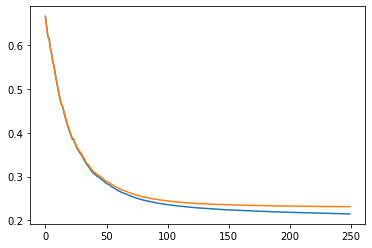

In [11]:
plt.plot(evals_result['train']['logloss'])
plt.plot(evals_result['test']['logloss'])

In [12]:
y_pred = model.predict(d_test)
y_pred_class = (y_pred > 0.50)
acc_xgb = (y_pred_class == y_test.values).sum().astype(float) / len(y_pred_class)*100

print(acc_xgb)

90.4745936332681


In [13]:
y_pred2 = model.predict(d_train)
y_pred_class2 = (y_pred2 > 0.50)
acc_xgb2 = (y_pred_class2 == y_train.values).sum().astype(float) / len(y_pred_class2)*100

print(acc_xgb2)

91.25587716107675


In [14]:
confusion_matrix(y_test, y_pred_class,normalize='true')

array([[0.94948256, 0.05051744],
       [0.13999069, 0.86000931]])

In [15]:
confusion_matrix(y_train, y_pred_class2,normalize='true')

array([[0.9575276 , 0.0424724 ],
       [0.13241006, 0.86758994]])

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
logit_roc_auc = roc_auc_score(y_test, y_pred_class) 
print(logit_roc_auc)

0.9047459363326811


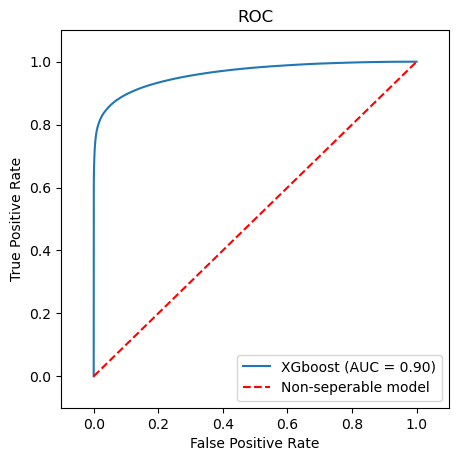

In [17]:
plt.figure(dpi=100,figsize=(5,5))
plt.plot(fpr, tpr, label='XGboost (AUC = %0.2f)' % logit_roc_auc) 
plt.plot([0, 1], [0, 1],'r--',label='Non-seperable model')
#plt.plot([0, 0], [0, 1],'b--',label='Perfect model')
#plt.plot([0, 1], [1, 1],'b--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')

In [18]:
model.save_model("xgb_no_coords.model")

In [19]:
def od(arr):
    odds = np.exp(arr)
    prob = odds / (1 + odds)
    return prob - 0.5

In [20]:
%%time
df_sample = df_train.sample(300000)
X_sample = df_sample[X_names]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

Wall time: 4h 9min 2s


In [21]:
np.savetxt('shap_values_final.csv', shap_values, delimiter=',')

In [22]:
X_sample.to_csv('shap_X_sample_final.csv')
df_sample.to_csv('shap_df_sample_final.csv')